# Köppen-Geiger Climate Composition per NUTS-2 Region

This notebook computes, for each NUTS-2 region in Europe, the composition of Köppen–Geiger climate classes based on a raster dataset. It produces a GeoDataFrame with climate percentages per region, plus some quick validation plots and (optionally) exports the result for further analysis or modelling.


In [17]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd

import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats

import matplotlib.pyplot as plt

print("✅ Libraries imported")


✅ Libraries imported


## STEP 1 — Load NUTS-2 regions from Eurostat GISCO
We download the official NUTS-2 geometries directly from the Eurostat GISCO service (GeoJSON format). If you already have the file locally, you can comment the download and read it from disk instead.


In [18]:
# URL for NUTS 2021, 1:20M, EPSG:4326 (WGS84)
nuts_url = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_20M_2021_4326.geojson"

print("Downloading NUTS-2 GeoJSON from Eurostat GISCO...")
nuts_gdf = gpd.read_file(nuts_url)
print(f"Total NUTS regions loaded: {len(nuts_gdf)}")
print(f"Original CRS: {nuts_gdf.crs}")

# Keep only NUTS-2 level
nuts_2 = nuts_gdf[nuts_gdf["LEVL_CODE"] == 2].copy()
nuts_2 = nuts_2.reset_index(drop=True)
print(f"NUTS-2 regions: {len(nuts_2)}")

nuts_2.head()


Total NUTS regions loaded: 2010
Original CRS: EPSG:4326
NUTS-2 regions: 334


,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,geometry
0,CZ05,2,CZ,Severovýchod,Severovýchod,0.0,0,0,"POLYGON ((15.24294 50.98354, 15.37694 50.80168..."
1,CZ06,2,CZ,Jihovýchod,Jihovýchod,0.0,0,0,"POLYGON ((15.49695 49.86118, 16.39363 49.58061..."
2,CZ07,2,CZ,Střední Morava,Střední Morava,0.0,0,0,"POLYGON ((18.27056 49.49155, 18.4036 49.39675,..."
3,CZ08,2,CZ,Moravskoslezsko,Moravskoslezsko,0.0,0,0,"POLYGON ((18.03506 50.06577, 18.32694 49.9285,..."
4,DE11,2,DE,Stuttgart,Stuttgart,0.0,0,0,"POLYGON ((9.80099 49.69547, 9.94045 49.49829, ..."


## STEP 2 — Load Köppen–Geiger - Combined climate dataset across all periods
Update `koppen_raster_path` with the path to your Köppen–Geiger raster file. The raster should cover (at least) the European domain.
We read basic metadata like CRS, bounds and shape, and store the raster CRS and `nodata` value.


In [19]:
"""
Module for processing Köppen-Geiger climate classification rasters and
computing zonal statistics over NUTS-2 regions.

This module:
- Loads raster metadata,
- Reprojects NUTS polygons to raster CRS,
- Computes zonal statistics per climate class,
- Calculates percentage coverage per polygon,
- Identifies dominant climate class,
- Renames output fields,
- Combines all periods into a unified GeoDataFrame.

Outputs:
    final_gdf (GeoDataFrame): Combined climate dataset across all periods.
"""


# List of raster input files, each representing a climatic period
# based on the Köppen-Geiger climate classification.
# ---------------------------------------------------------------------
raster_files = [
    "koppen_1901_1930.tif",
    "koppen_1931_1960.tif",
    "koppen_1961_1990.tif",
    "koppen_1991_2020.tif",
]

final_list = []  # Stores each intermediate GeoDataFrame before concatenation.


# ======================================================
# Main loop: iterate through each raster period
# ======================================================
for raster_path in raster_files:
    print(f"\n==============================")
    print(f" Processing raster: {raster_path}")
    print(f"==============================\n")

    # ---------------------------------------------------------
    # 1. Load raster metadata (CRS and NoData value)
    # ---------------------------------------------------------
    with rasterio.open(raster_path) as src:
        raster_crs    = src.crs
        raster_nodata = src.nodata

    # ---------------------------------------------------------
    # 2. Reproject NUTS polygons to match raster CRS
    # ---------------------------------------------------------
    nuts_proj = nuts_2.to_crs(raster_crs)

    # ---------------------------------------------------------
    # 3. Compute zonal statistics for each polygon.
    #    `categorical=True` counts pixel occurrences per class.
    # ---------------------------------------------------------
    stats = zonal_stats(
        nuts_proj,
        raster_path,
        categorical=True,
        nodata=raster_nodata,
        all_touched=False
    )

    climate_df = pd.DataFrame(stats).fillna(0)

    # Identify raster class integer columns (e.g., 1, 2, 3...)
    class_cols = [c for c in climate_df.columns if isinstance(c, (int, np.integer))]

    # ---------------------------------------------------------
    # Compute the total number of valid pixels per polygon
    # ---------------------------------------------------------
    climate_df["total_pixels"] = climate_df[class_cols].sum(axis=1)
    climate_df["total_pixels"] = climate_df["total_pixels"].replace(0, np.nan)

    # ---------------------------------------------------------
    # 4. Create % coverage columns for each climate class
    # ---------------------------------------------------------
    for col in class_cols:
        pct_col = f"pct_{int(col)}"
        climate_df[pct_col] = climate_df[col] / climate_df["total_pixels"]

    climate_df = climate_df.fillna(0)


    # =====================================================
    # Köppen–Geiger legend (numeric class -> climate code)
    # =====================================================
    koppen_legend = {
        1: "Af",  2: "Am",  3: "Aw",
        4: "BWh", 5: "BWk", 6: "BSh", 7: "BSk",
        8: "Csa", 9: "Csb", 10: "Csc",
        11: "Cwa", 12: "Cwb", 13: "Cwc",
        14: "Cfa", 15: "Cfb", 16: "Cfc",
        17: "Dsa", 18: "Dsb", 19: "Dsc", 20: "Dsd",
        21: "Dwa", 22: "Dwb", 23: "Dwc", 24: "Dwd",
        25: "Dfa", 26: "Dfb", 27: "Dfc", 28: "Dfd",
        29: "ET", 30: "EF",
}

    # ---------------------------------------------------------
    # 5. Compute dominant climatic class per region
    # ---------------------------------------------------------
    climate_df["dominant_class"]  = climate_df[class_cols].idxmax(axis=1).astype(int)
    climate_df["dominant_koppen"] = climate_df["dominant_class"].map(koppen_legend)

    # ---------------------------------------------------------
    # 6. Rename pct_* columns using real Köppen-Geiger names
    # ---------------------------------------------------------
    pct_cols = [c for c in climate_df.columns if isinstance(c, str) and c.startswith("pct_")]

    rename_map = {}
    for col in pct_cols:
        class_id = int(col.split("_")[1])
        if class_id in koppen_legend:
            rename_map[col] = f"pct_{koppen_legend[class_id]}"

    climate_pct = climate_df[pct_cols + ["dominant_class", "dominant_koppen"]] \
                    .rename(columns=rename_map)

    # ---------------------------------------------------------
    # 7. Build the GeoDataFrame for the current raster period
    # ---------------------------------------------------------
    temp = gpd.GeoDataFrame(
        pd.concat(
            [
                nuts_proj[["NUTS_ID", "NUTS_NAME", "CNTR_CODE", "geometry"]].reset_index(drop=True),
                climate_pct.reset_index(drop=True),
            ],
            axis=1
        ),
        crs=nuts_proj.crs
    )

    # Add period identifier (filename without extension)
    temp["centroide"] = os.path.splitext(raster_path)[0]

    final_list.append(temp)


# ======================================================
# 8. Concatenate all periods into one final GeoDataFrame
# ======================================================
final_gdf = gpd.GeoDataFrame(pd.concat(final_list, ignore_index=True), crs=nuts_2.crs)

print("\n====================================================")
print(" FINAL final_gdf created successfully")
print(" Shape:", final_gdf.shape)
print("====================================================\n")


# ---------------------------------------------------------------------
# Replace period strings with numerical reference years
# ---------------------------------------------------------------------
final_gdf["centroide"] = final_gdf["centroide"].replace({
    "koppen_1901_1930": "1915",
    "koppen_1931_1960": "1945",
    "koppen_1961_1990": "1975",
    "koppen_1991_2020": "2000"
})

# Convert reference period to numeric type
final_gdf["centroide"] = final_gdf["centroide"].astype(int)

final_gdf.head()



 Processing raster: koppen_1901_1930.tif


 Processing raster: koppen_1931_1960.tif


 Processing raster: koppen_1961_1990.tif


 Processing raster: koppen_1991_2020.tif


 FINAL final_gdf created successfully
 Shape: (1336, 30)



,NUTS_ID,NUTS_NAME,CNTR_CODE,geometry,pct_Dfb,pct_Dfc,pct_ET,pct_Cfb,pct_BSk,pct_EF,...,pct_Aw,pct_Cwa,pct_Cwb,pct_Dsa,pct_Cfc,pct_BWh,pct_Csc,dominant_class,dominant_koppen,centroide
0,CZ05,Severovýchod,CZ,"POLYGON ((15.24294 50.98354, 15.37694 50.80168...",0.939132,0.060424,0.000444,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,Dfb,1915
1,CZ06,Jihovýchod,CZ,"POLYGON ((15.49695 49.86118, 16.39363 49.58061...",1.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,Dfb,1915
2,CZ07,Střední Morava,CZ,"POLYGON ((18.27056 49.49155, 18.4036 49.39675,...",0.945800,0.054200,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,Dfb,1915
3,CZ08,Moravskoslezsko,CZ,"POLYGON ((18.03506 50.06577, 18.32694 49.9285,...",0.943167,0.056833,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,Dfb,1915
4,DE11,Stuttgart,DE,"POLYGON ((9.80099 49.69547, 9.94045 49.49829, ...",0.795130,0.000000,0.000000,0.20487,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,Dfb,1915


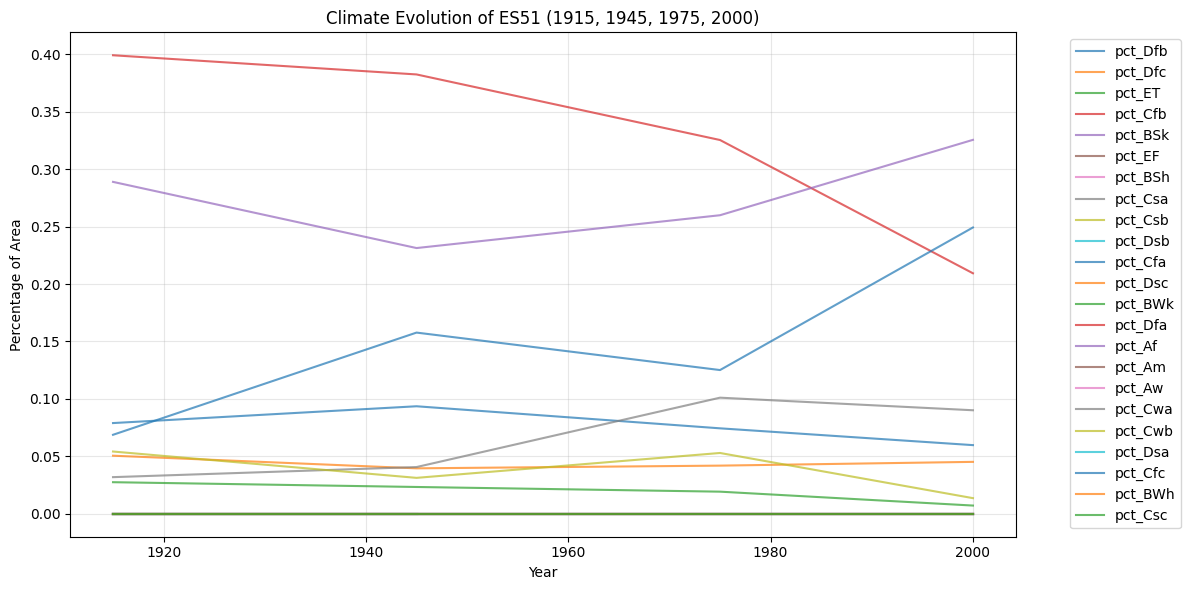

In [20]:
# Filter the data for a specific NUTS region (ES51 in this case)
es51 = final_gdf[final_gdf["NUTS_ID"] == "ES51"].sort_values("centroide")

# Identify columns containing climate percentage values
climate_cols = [c for c in es51.columns if c.startswith("pct_")]

plt.figure(figsize=(12, 6))

for col in climate_cols:
    plt.plot(es51["centroide"], es51[col], label=col, alpha=0.7)

plt.title("Climate Evolution of ES51 (1915, 1945, 1975, 2000)")
plt.xlabel("Year")
plt.ylabel("Percentage of Area")
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## STEP 2 — Generate future data (2000 - 2015)
Update `koppen_raster_path` with the path to your Köppen–Geiger raster file. The raster should cover (at least) the European domain.
We read basic metadata like CRS, bounds and shape, and store the raster CRS and `nodata` value.


In [21]:
from scipy.interpolate import UnivariateSpline

# ============================================================
# Identify all climate percentage columns (pct_*)
# ============================================================
climate_columns = [c for c in final_gdf.columns if c.startswith("pct_")]

# Preserve the full set of columns from the historical final_gdf
full_columns = final_gdf.columns.tolist()

# Target years to generate synthetic data
future_years = np.arange(2000, 2026)

generated_list = []


# =====================================================================
# Main loop: generate synthetic climate series for each NUTS region
# =====================================================================
for nuts_id, group in final_gdf.groupby("NUTS_ID"):

    # ---------------------------------------------------------------
    # Sort historical records by the temporal reference
    # ---------------------------------------------------------------
    group = group.sort_values("centroide")

    # ---------------------------------------------------------------
    # Create output frame for this region with all required columns
    # ---------------------------------------------------------------
    df_future = pd.DataFrame({
        "NUTS_ID": nuts_id,
        "centroide": future_years
    })

    # ---------------------------------------------------------------
    # Copy constant attributes from the last available record
    # ---------------------------------------------------------------
    last_row = group.iloc[-1]

    constant_cols = [
        c for c in full_columns
        if c not in climate_columns and c not in ["centroide"]
    ]

    for c in constant_cols:
        # These attributes do not change over time (geometry, names, etc.)
        df_future[c] = last_row[c]

    # ===============================================================
    # Generate synthetic data for each pct_* climate column
    # ===============================================================
    for col in climate_columns:

        # Historical input data
        x = group["centroide"].values
        y = group[col].values

        # -----------------------------------------------------------
        # 1) Smooth spline to capture long-term climatic trend
        # -----------------------------------------------------------
        spline = UnivariateSpline(x, y, k=2, s=0.0001)
        base = spline(future_years)

        # -----------------------------------------------------------
        # 2) Multidecadal oscillation (~13-year quasi-periodicity)
        # -----------------------------------------------------------
        cycle = 0.01 * np.sin(2 * np.pi * (future_years - 2000) / 13)

        # -----------------------------------------------------------
        # 3) AR(1) noise process for interannual variability
        # -----------------------------------------------------------
        ar = np.zeros(len(future_years))
        rho = 0.7      # persistence of anomalies
        sigma = 0.003  # magnitude of random shocks

        for t in range(1, len(ar)):
            ar[t] = rho * ar[t - 1] + np.random.normal(0, sigma)

        # -----------------------------------------------------------
        # 4) Combine components into final synthetic series
        # -----------------------------------------------------------
        values = base + cycle + ar

        # Keep values within physical bounds [0, 1]
        values = np.clip(values, 0, 1)

        df_future[col] = values

    # Append regional synthetic dataset to list
    generated_list.append(df_future)


# =====================================================================
# Merge all regions into a complete GeoDataFrame
# =====================================================================
future_gdf = pd.concat(generated_list, ignore_index=True)

# ============================================================
# Reorder columns so that the first 7 match the required layout
# ============================================================
first_columns = [
    "NUTS_ID",
    "NUTS_NAME",
    "CNTR_CODE",
    "geometry",
    "centroide",
    "dominant_class",
    "dominant_koppen"
]

# The remaining columns retain the original order
remaining_columns = [c for c in full_columns if c not in first_columns]

# Final ordered dataframe
future_gdf = future_gdf[first_columns + remaining_columns]

In [22]:
future_gdf = future_gdf.rename(columns={
    "NUTS_ID": "geo",
    "centroide": "year"     # por ejemplo, si quieres cambiar esta también
})

In [23]:
future_gdf.head()

,geo,NUTS_NAME,CNTR_CODE,geometry,year,dominant_class,dominant_koppen,pct_Dfb,pct_Dfc,pct_ET,...,pct_Dfa,pct_Af,pct_Am,pct_Aw,pct_Cwa,pct_Cwb,pct_Dsa,pct_Cfc,pct_BWh,pct_Csc
0,AL01,Veri,AL,POLYGON ((19.734918607000054 42.63237665100007...,2000,14,Cfa,0.262840,0.045226,0.000529,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000
1,AL01,Veri,AL,POLYGON ((19.734918607000054 42.63237665100007...,2001,14,Cfa,0.266223,0.049444,0.004276,...,0.006410,0.004158,0.005114,0.003925,NaN,NaN,0.003213,0.004429,0.003599,0.011334
2,AL01,Veri,AL,POLYGON ((19.734918607000054 42.63237665100007...,2002,14,Cfa,0.263298,0.054817,0.008871,...,0.011103,0.007373,0.003404,0.005281,NaN,NaN,0.007562,0.011128,0.008819,0.012137
3,AL01,Veri,AL,POLYGON ((19.734918607000054 42.63237665100007...,2003,14,Cfa,0.259116,0.056619,0.010746,...,0.004322,0.009542,0.006677,0.008123,NaN,NaN,0.008221,0.008142,0.013422,0.011995
4,AL01,Veri,AL,POLYGON ((19.734918607000054 42.63237665100007...,2004,14,Cfa,0.253957,0.048818,0.010627,...,0.008443,0.016268,0.005714,0.007192,NaN,NaN,0.000000,0.009839,0.012205,0.013995


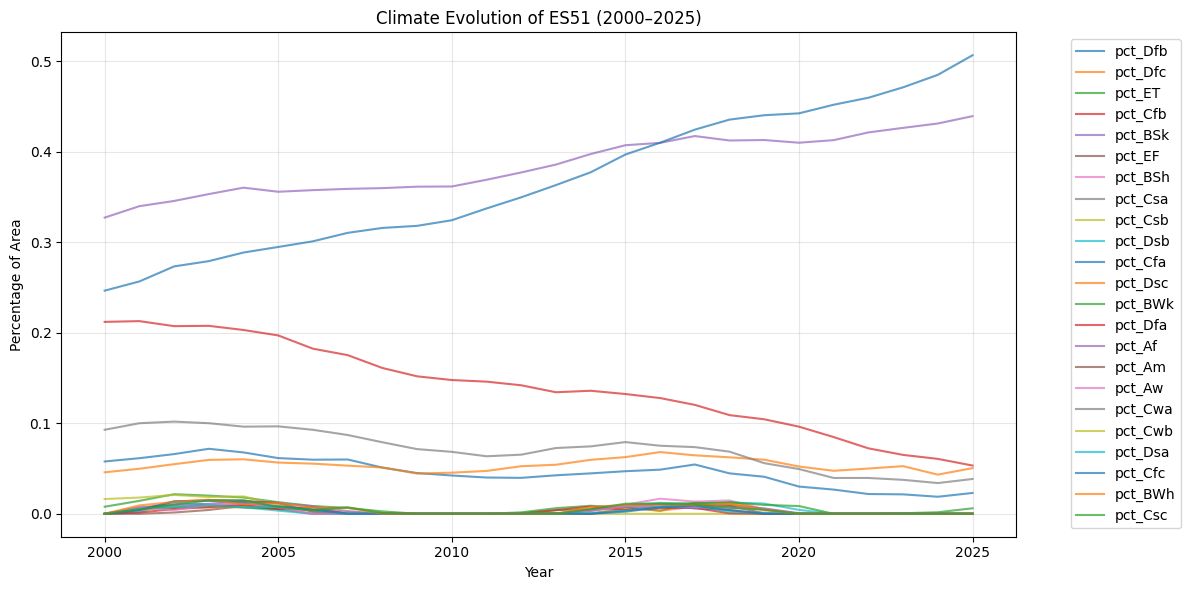

In [24]:
# Filter the data for a specific NUTS region (ES51 in this case)
es51 = future_gdf[future_gdf["geo"] == "ES51"].sort_values("year")

# Identify columns containing climate percentage values
climate_cols = [c for c in es51.columns if c.startswith("pct_")]

plt.figure(figsize=(12, 6))

for col in climate_cols:
    plt.plot(es51["year"], es51[col], label=col, alpha=0.7)

plt.title("Climate Evolution of ES51 (2000–2025)")
plt.xlabel("Year")
plt.ylabel("Percentage of Area")
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### Extract gdf_future in csv file

In [25]:
df_export = future_gdf.drop(columns="geometry", errors="ignore")

# Export
df_export.to_csv("future_climate_2000_2025.csv", index=False)

print("Archivo CSV generado: future_climate_2000_2025.csv")

Archivo CSV generado: future_climate_2000_2025.csv


In [26]:
pd.read_csv("future_climate_2000_2025.csv").head()

,geo,NUTS_NAME,CNTR_CODE,year,dominant_class,dominant_koppen,pct_Dfb,pct_Dfc,pct_ET,pct_Cfb,...,pct_Dfa,pct_Af,pct_Am,pct_Aw,pct_Cwa,pct_Cwb,pct_Dsa,pct_Cfc,pct_BWh,pct_Csc
0,AL01,Veri,AL,2000,14,Cfa,0.262840,0.045226,0.000529,0.142439,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000
1,AL01,Veri,AL,2001,14,Cfa,0.266223,0.049444,0.004276,0.140955,...,0.006410,0.004158,0.005114,0.003925,NaN,NaN,0.003213,0.004429,0.003599,0.011334
2,AL01,Veri,AL,2002,14,Cfa,0.263298,0.054817,0.008871,0.135389,...,0.011103,0.007373,0.003404,0.005281,NaN,NaN,0.007562,0.011128,0.008819,0.012137
3,AL01,Veri,AL,2003,14,Cfa,0.259116,0.056619,0.010746,0.132024,...,0.004322,0.009542,0.006677,0.008123,NaN,NaN,0.008221,0.008142,0.013422,0.011995
4,AL01,Veri,AL,2004,14,Cfa,0.253957,0.048818,0.010627,0.125660,...,0.008443,0.016268,0.005714,0.007192,NaN,NaN,0.000000,0.009839,0.012205,0.013995
